In [1]:
# General Dependencies
import timeit, os
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose, batch_recompose, overlapping_batch_decompose, overlapping_batch_recompose
from trefide.reformat import overlapping_component_reformat

# Plot & Video Dependencies
#import mpdf_plot
import matplotlib.pyplot as plt
import mpdf_plot

# Plots
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import write_mpl, play_cv2

# Other
from scipy.stats import norm

%load_ext autoreload
%autoreload 2

# Make Videowriting Function

In [2]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def write_video(mov, title, filename, clip=[0,1], mov_width=24):
    
    d1, d2, num_frames = mov.shape
    
    # Find Figsize As To Almost Fit The Screen
    aspect_ratio = d1/d2
    mov_height = int(np.ceil(aspect_ratio * mov_width)) # account for cbar
    
    Yd_1 = (mov).transpose([2,0,1]);
    Yd_1 = Yd_1 - Yd_1.min(axis=0, keepdims=True);
    Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min());
    Yd_1 = np.clip(Yd_1, clip[0], clip[1]);
    Yd_1 = (Yd_1 - Yd_1.min())/(Yd_1.max() - Yd_1.min());

    fig = plt.figure(figsize=(mov_width,mov_height));
    ax1 = plt.subplot(1,1,1)
    ax1.set(title=title)
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold")
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.tight_layout()

    img1 = ax1.imshow(Yd_1[0,:,:],vmin=Yd_1.min(),vmax=Yd_1.max(),cmap="Greys_r");
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(img1, cax=cax,orientation='vertical',spacing='uniform')

    def update(i):
        img1.set_data(Yd_1[i+1,:,:]);
        ax1.set(title=title + " Frame: {}".format(i))
        return [img1]

    ani = animation.FuncAnimation(fig, update, frames=num_frames-1, blit=True);
    ani.save(filename, fps=60)

In [3]:
def compute_thresh(samples, conf=5):
    #mu = np.mean(samples)
    #std = np.sqrt(np.var(samples))
    #return (norm.ppf(conf) * std) + mu
    return np.percentile(samples, conf)
def tv_norm(image):
    return np.sum(np.abs(image[:,:-1] - image[:,1:])) + np.sum(np.abs(image[:-1,:] - image[1:,:]))

def spatial_test_statistic(component):
    d1, d2 = component.shape
    return (tv_norm(component) *d1*d2)/ (np.sum(np.abs(component)) * (d1*(d2-1) + d2 * (d1-1)))

def temporal_test_statistic(signal):
    return np.sum(np.abs(signal[2:] + signal[:-2] - 2*signal[1:-1])) / np.sum(np.abs(signal))

In [4]:
def determine_thresholds(mov_dims, block_dims, num_components, conf=5, plot=False):
    
    # Simulate Noise Movie
    noise_mov = np.ascontiguousarray(np.reshape(np.random.randn(np.prod(mov_dims)), mov_dims))
    
    # Perform Blockwise PMD Of Noise Matrix In Parallel
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(mov_dims[0], mov_dims[1], mov_dims[2],
                                    noise_mov, block_dims[0], block_dims[1],
                                    1e3, 1e3,
                                    num_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)
    
    # Gather Test Statistics
    spatial_stat = []
    temporal_stat = []
    num_blocks = int((mov_dims[0] / block_dims[0]) * (mov_dims[1] / block_dims[1]))
    for block_idx in range(num_blocks): 
        for k in range(int(block_ranks[block_idx])):
            spatial_stat.append(spatial_test_statistic(spatial_components[block_idx,:,:,k]))
            temporal_stat.append(temporal_test_statistic(temporal_components[block_idx,k,:]))

    # Compute Thresholds
    spatial_thresh = compute_thresh(spatial_stat, conf=conf)
    temporal_thresh = compute_thresh(temporal_stat, conf=conf)
    
    if plot:
        fig, ax = plt.subplots(2,2,figsize=(8,8))
        ax[0,0].scatter(spatial_stat, temporal_stat, marker='x', c='r', alpha = .2)
        ax[0,0].axvline(spatial_thresh)
        ax[0,0].axhline(temporal_thresh)
        ax[0,1].hist(temporal_stat, bins=20, color='r')
        ax[0,1].axvline(temporal_thresh)
        ax[0,1].set_title("Temporal Threshold: {}".format(temporal_thresh))
        ax[1,0].hist(spatial_stat, bins=20, color='r')
        ax[1,0].axvline(spatial_thresh)
        ax[1,0].set_title("Spatial Threshold: {}".format(spatial_thresh))
        plt.show()
    
    return spatial_thresh, temporal_thresh
    

# Record System Info

In [5]:
!uname -a

Linux ubuntu-box 4.10.0-33-generic #37~16.04.1-Ubuntu SMP Fri Aug 11 14:07:24 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


In [6]:
!cpuinfo

Intel(R) processor family information utility, Version 2018 Update 2 Build 20180125 (id: 18157)
Copyright (C) 2005-2018 Intel Corporation.  All rights reserved.

=====  Processor composition  =====
Processor name    : Intel(R) Core(TM) i7-6850K  
Packages(sockets) : 1
Cores             : 6
Processors(CPUs)  : 12
Cores per package : 6
Threads per core  : 2

=====  Processor identification  =====
Processor	Thread Id.	Core Id.	Package Id.
0       	0   		0   		0   
1       	0   		1   		0   
2       	0   		2   		0   
3       	0   		3   		0   
4       	0   		4   		0   
5       	0   		5   		0   
6       	1   		0   		0   
7       	1   		1   		0   
8       	1   		2   		0   
9       	1   		3   		0   
10      	1   		4   		0   
11      	1   		5   		0   
=====  Placement on packages  =====
Package Id.	Core Id.	Processors
0   		0,1,2,3,4,5		(0,6)(1,7)(2,8)(3,9)(4,10)(5,11)

=====  Cache sharing  =====
Cache	Size		Processors
L1	32  KB		(0,6)(1,7)(2,8)(3,9)(4,10)(5,11)
L2	256 KB		(0,6)(1,7)(2,8)(3,9)(

# Set Parameters

In [7]:
max_components = 50
max_iters_main = 10
max_iters_init = 40
consec_failures = 3
d_sub=2
t_sub=2
tol = 5e-3
ext = "../trefide"

# Tolias 3P

In [8]:
# Set Data Information
dataset = "3P"
filename = os.path.join(ext, "data", "18252_5_00006_00001_trimmed_d2_v1_rig_10.npz")
block_height = 20
block_width = 20

In [9]:
mov = np.load(filename)['data'][20:-20,20:-20,:].astype(np.float64).copy()  # Crop Problematic Border
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [10]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Simulate Thresholds

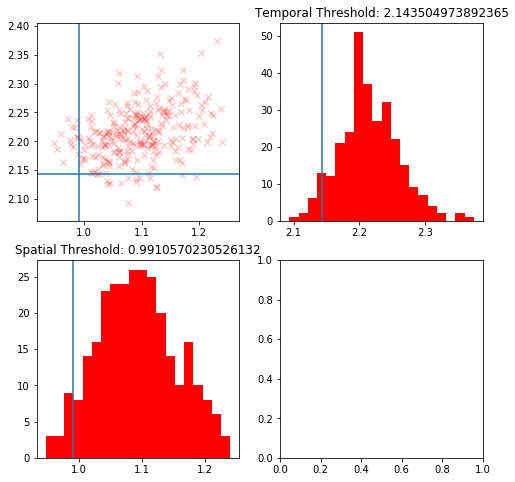

In [11]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Run Decomposition

In [12]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            spatial_thresh, temporal_thresh,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [13]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

12.4122444042001

## Produce Performance Diagnostics

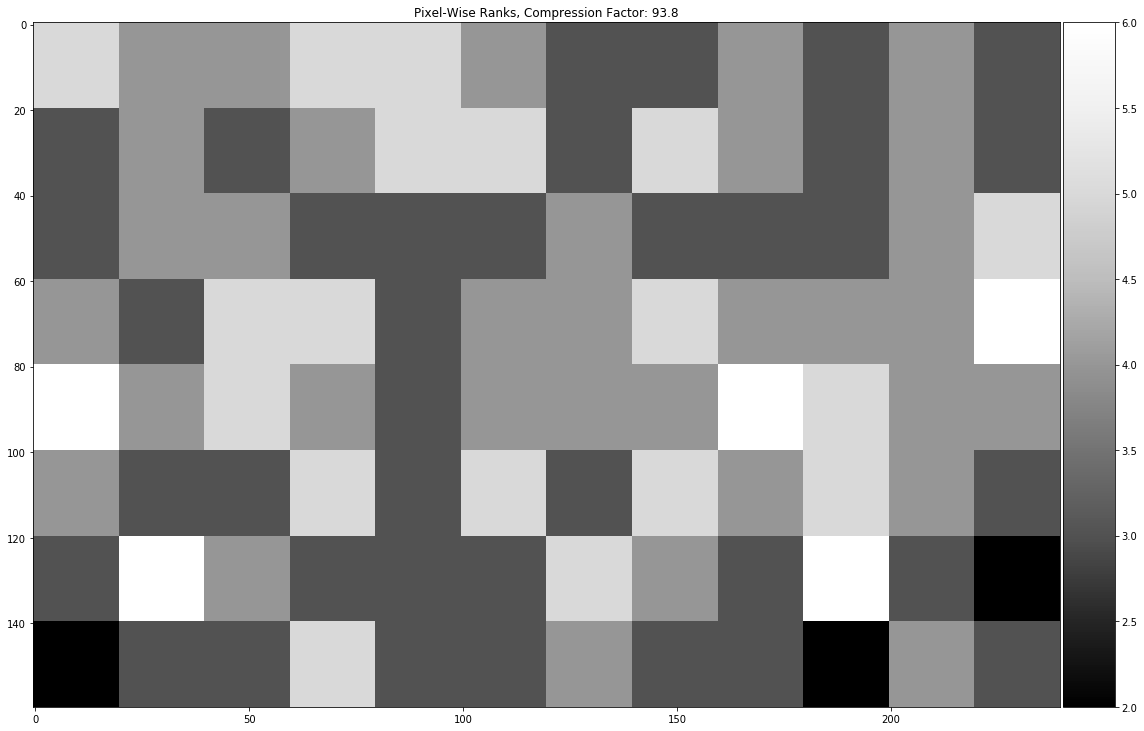

In [14]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [3.7e-02 2.3e-01]
Local correlation:  range [-4.3e-01 1.0e+00]
Local correlation:  range [-7.4e-02 1.3e-01]


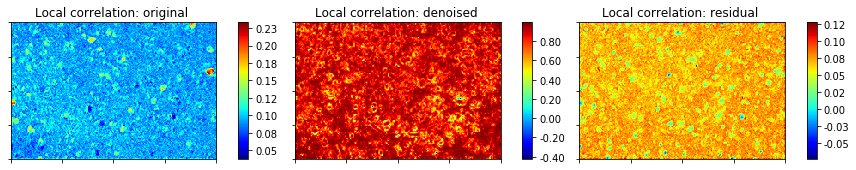

In [15]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

In [16]:
play_cv2(np.hstack([mov, mov_denoised, mov - mov_denoised]))

## Generate Paper Figs

Frame:  range [-2.0e+00 7.6e+00]
Frame:  range [-1.5e+00 4.1e+00]
Frame:  range [-3.6e+00 7.4e+00]
SNR:  range [1.1e+00 1.4e+00]
SNR:  range [1.2e+00 4.0e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [4.6e-02 2.1e-01]
Local correlation:  range [-1.7e-02 1.3e-01]


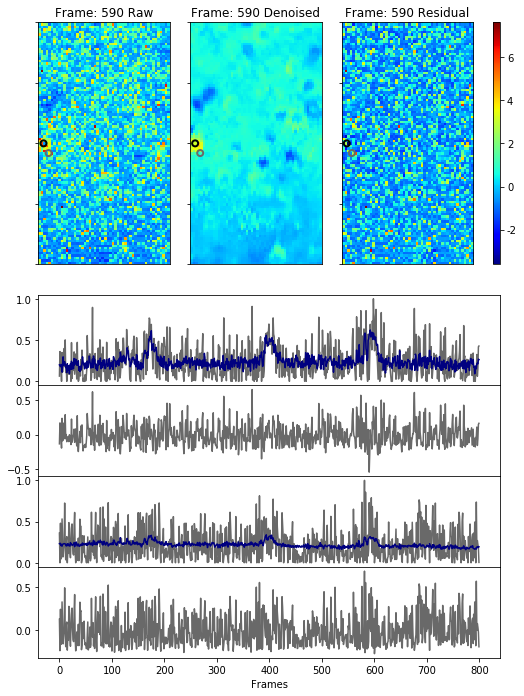

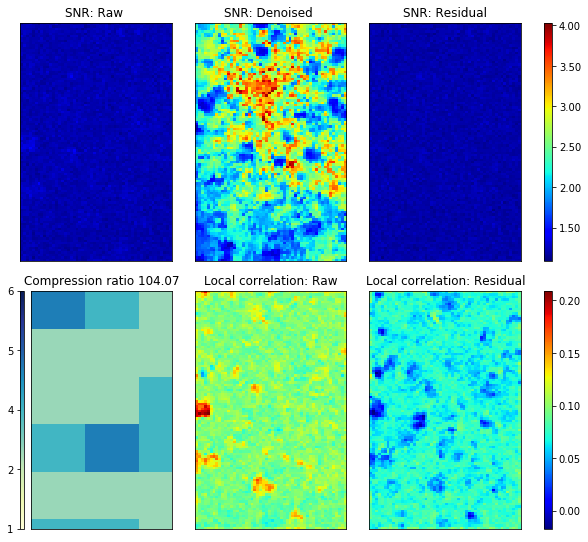

In [17]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[94, 2],
                    pixel_coor2=[98, 4],
                    frame_idx=590,
                    trace_seg=[0, 800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='3P_PMD_16_16.pdf')
plt.show()

## Save Results For Video

In [18]:
np.savez(os.path.join(ext, "data", "3P_PMD.npz"), mov, mov_denoised)

In [19]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [20]:
np.savez(os.path.join(ext, "data", "3P_Components_PMD.npz"), U, V)

# Q-State Bio Voltage Imaging

In [21]:
# Set Data Information
dataset = "Voltage"
filename = os.path.join(ext, "data", "denoised_IE017.npz")
block_height = 40
block_width = 40

In [22]:
mov = np.load(filename)['arr_0'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Simulate Thresholds

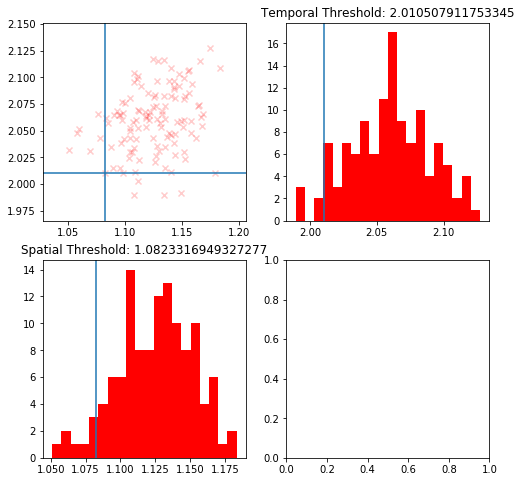

In [23]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Run Decomposition

In [24]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            spatial_thresh, temporal_thresh,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [25]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

30.4551216601998

## Produce Performance Diagnostics

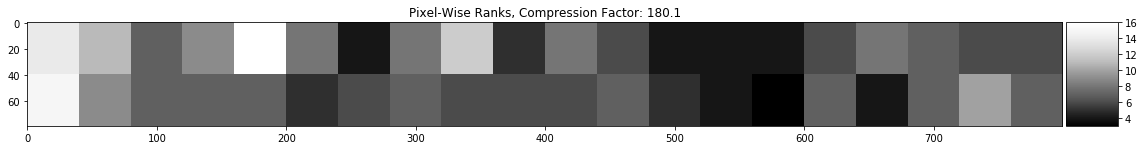

In [26]:
pixelwise_ranks(block_ranks['no_skew']['full'],
                fov_height, fov_width,
                num_frames, block_height, block_width)

Local correlation:  range [-1.9e-02 8.6e-01]
Local correlation:  range [-5.8e-01 1.0e+00]
Local correlation:  range [-1.9e-01 7.4e-02]


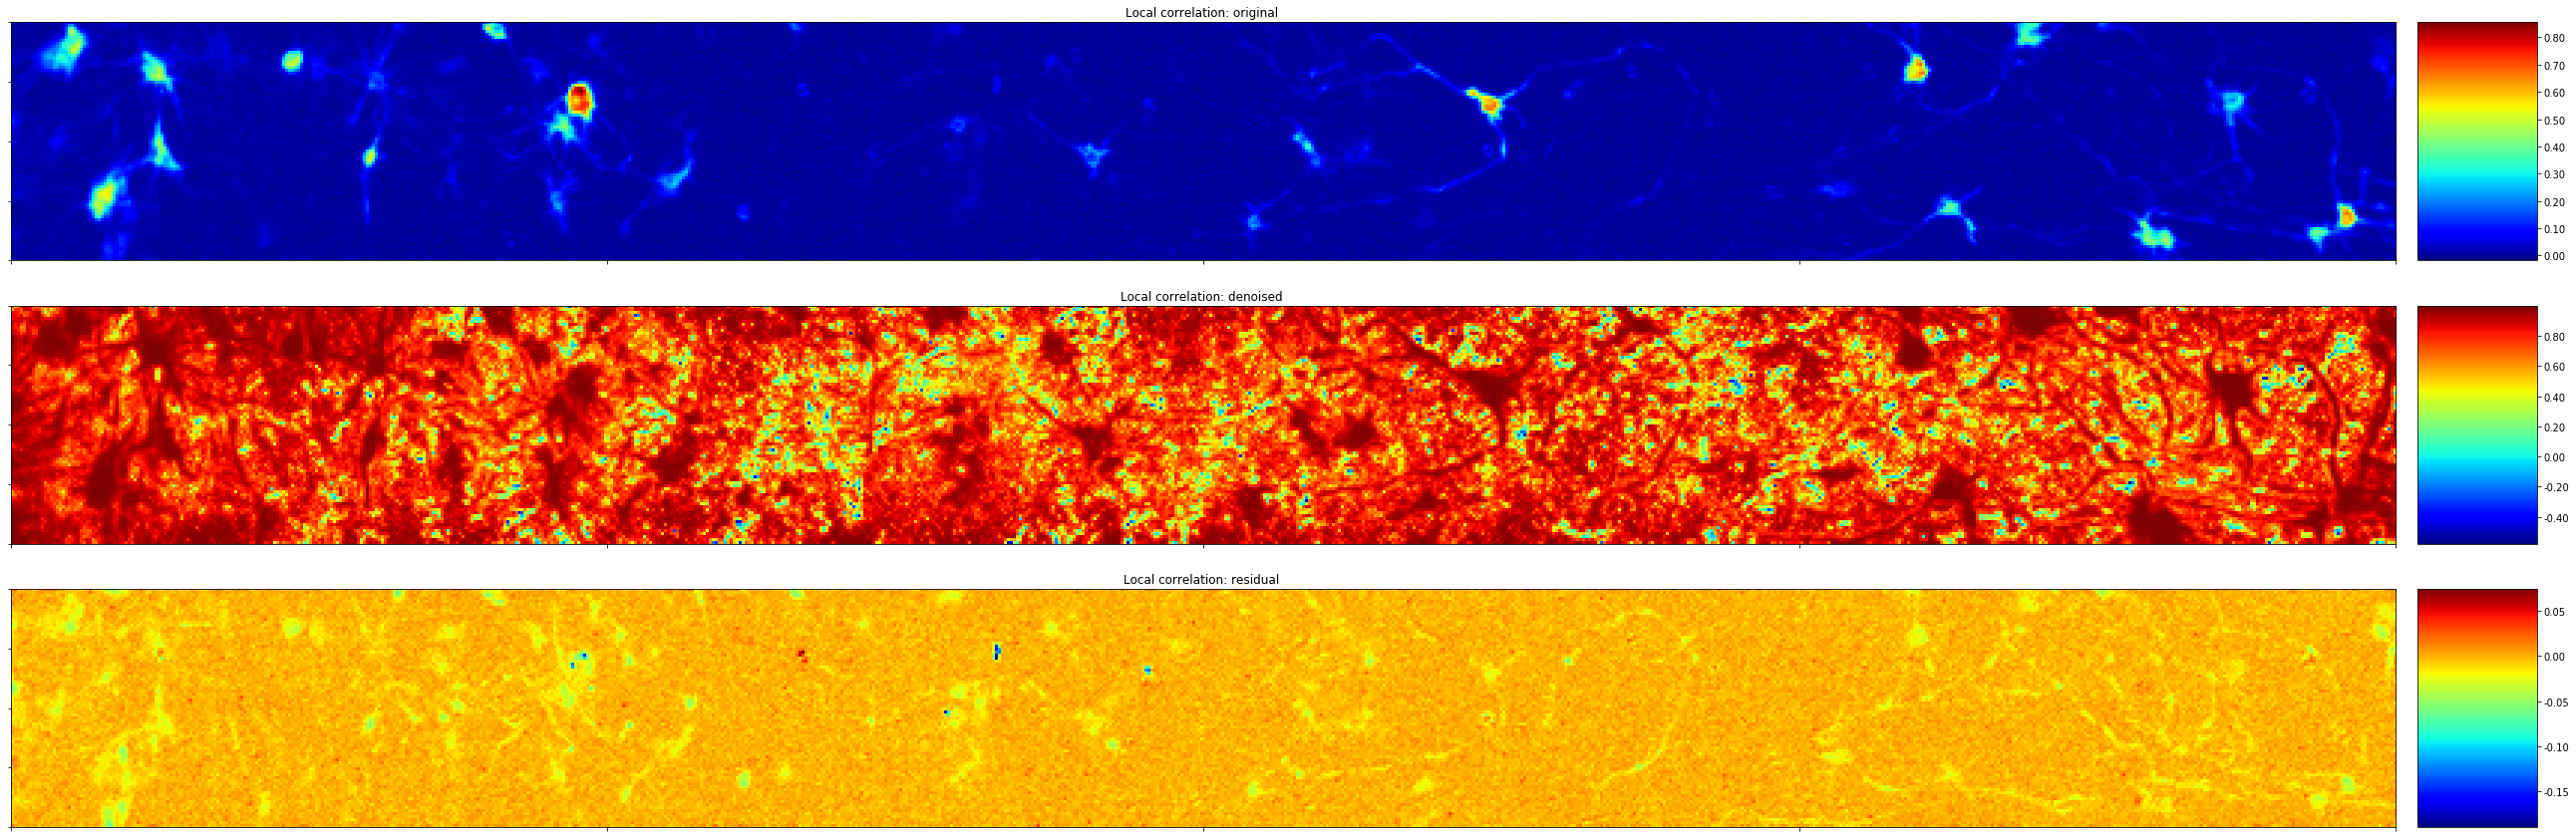

In [27]:
comparison_plot([mov, mov_denoised], plot_orientation="horizontal")

## Generate Paper Figs

Frame:  range [-3.3e+00 3.8e+00]
Frame:  range [-5.9e-01 1.3e+00]
Frame:  range [-3.2e+00 3.6e+00]
SNR:  range [1.1e+00 2.2e+00]
SNR:  range [1.4e+00 8.7e+00]
SNR:  range [1.1e+00 1.3e+00]
Local correlation:  range [-1.5e-02 6.7e-01]
Local correlation:  range [-5.5e-02 2.0e-02]


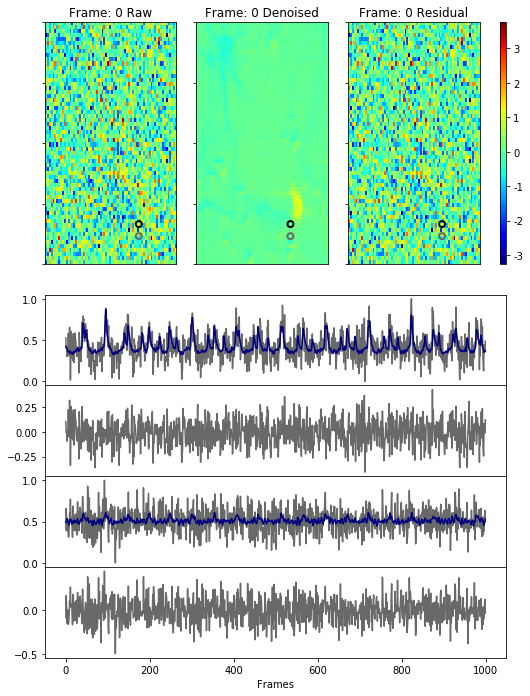

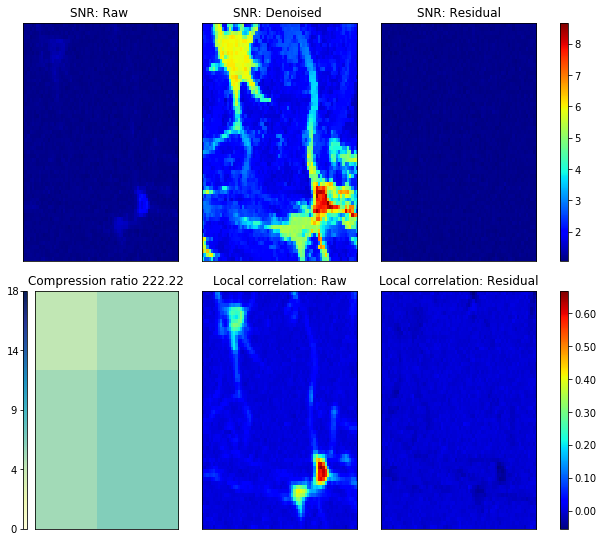

In [28]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[70, 780],
                    pixel_coor2=[73, 780],
                    frame_idx=4500,
                    trace_seg=[4500,5500],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='QState_PMD_80_80.pdf')
plt.show()

## Save Results For Video

In [29]:
np.savez(os.path.join(ext, "data", "QState_PMD.npz"), mov, mov_denoised)

In [30]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [31]:
np.savez(os.path.join(ext, "data", "QState_Components_PMD.npz"), U, V)

# Widefield

In [32]:
dataset = "Widefield"
filename = os.path.join(ext, "data", "hillman_stim1.npz")
block_height = 32
block_width = 32

In [33]:
mov = np.load(filename)['data'].astype(np.float64)[:,:,:-1].copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [34]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ian/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Simulate Thresholds

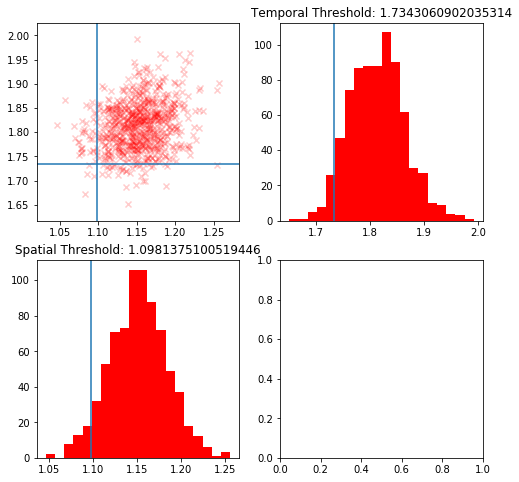

In [35]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Run Decomposition

In [36]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            spatial_thresh, temporal_thresh,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [37]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

12.505135435600096

## Produce Performance Diagnostics

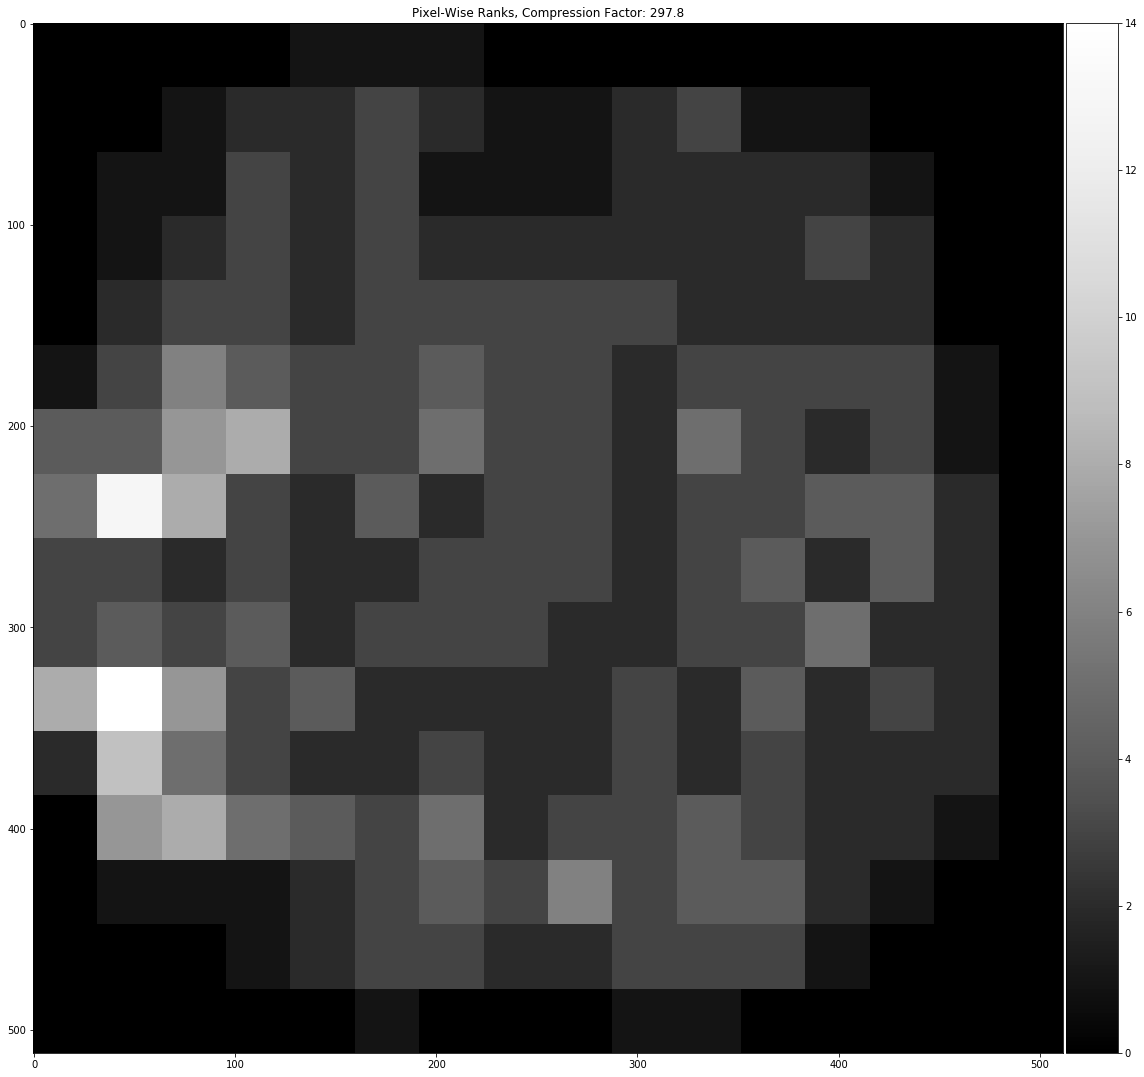

In [38]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-3.5e-02 8.8e-01]
Local correlation:  range [-2.3e-01 1.0e+00]
Local correlation:  range [-1.4e-01 1.4e-01]


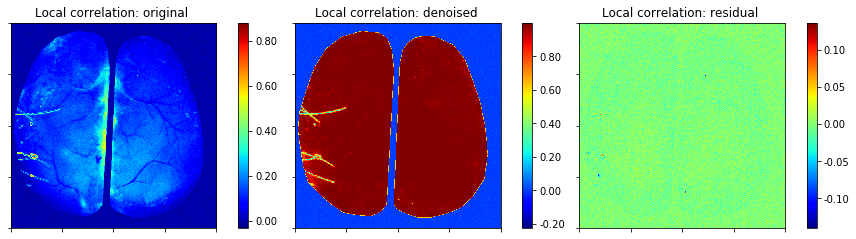

In [39]:
comparison_plot([mov + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01,
                 mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01], plot_orientation="vertical")

In [40]:
play_cv2(np.hstack([mov, mov_denoised, mov-mov_denoised]), magnification=1)

## Generate Paper Figs

Frame:  range [-3.4e+00 4.2e+00]
Frame:  range [-3.5e-01 3.4e-01]
Frame:  range [-3.4e+00 4.0e+00]
SNR:  range [1.1e+00 1.5e+00]
SNR:  range [2.4e+00 6.8e+00]
SNR:  range [1.1e+00 1.4e+00]
Local correlation:  range [1.8e-02 2.1e-01]
Local correlation:  range [-3.5e-02 2.9e-02]


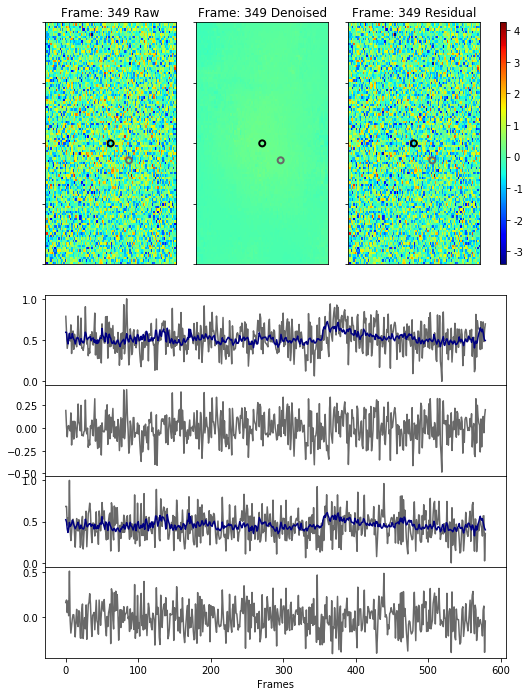

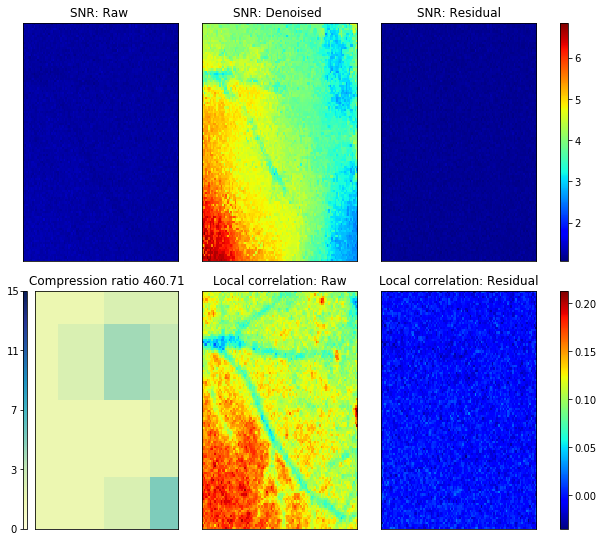

In [41]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[228, 386],
                    pixel_coor2=[235, 400],
                    frame_idx=569,
                    trace_seg=[220,800],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Widefield_PMD_64_64.pdf')
plt.show()

## Save Reuslts For Video

In [42]:
np.savez(os.path.join(ext, "data", "Widefield_PMD.npz"), mov, mov_denoised)

In [43]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [44]:
np.savez(os.path.join(ext, "data", "Widefield_Components_PMD.npz"), U, V)

# Endoscope

In [45]:
# Set Data Information
dataset = "Endoscope"
filename = os.path.join(ext, "data", "pc_blood_vessel_10Hz.npz")
block_height = 16
block_width = 16

In [46]:
mov = np.load(filename)['data'].astype(np.float64).copy()
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width
data = np.load("endoscope_prepared.npz")
mov = data['arr_0']
background = data['arr_1']
foreground = data['arr_2']

## Simulate Thresholds

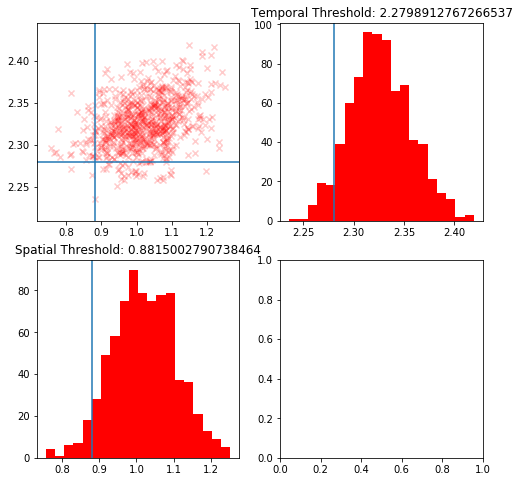

In [47]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Run Decomposition

In [48]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            foreground, block_height, block_width,
                                            spatial_thresh, temporal_thresh,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
denoised_foreground = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 


## Run Timing Evaluation

In [49]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    foreground, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=1)/1

220.4349621399997

## Produce Performance Diagnostics

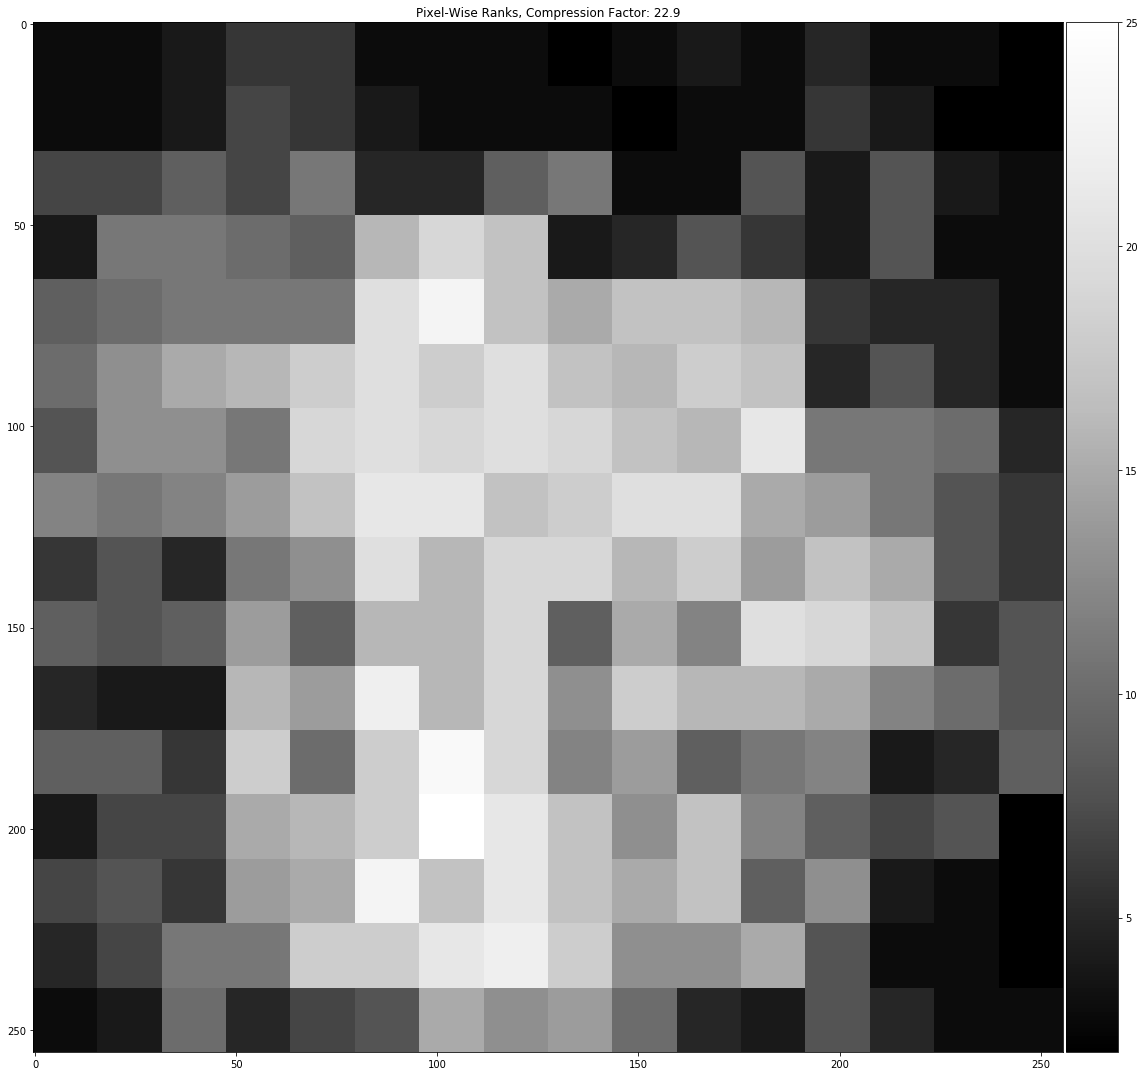

In [50]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [9.0e-02 9.8e-01]
Local correlation:  range [2.3e-01 1.0e+00]
Local correlation:  range [-1.7e-01 4.8e-02]


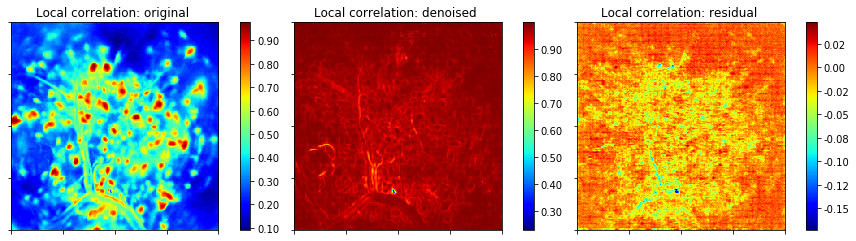

In [51]:
comparison_plot([foreground, denoised_foreground], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-4.3e+00 1.0e+01]
Frame:  range [-3.5e+00 9.0e+00]
Frame:  range [-2.9e+00 3.0e+00]
SNR:  range [1.2e+00 7.6e+00]
SNR:  range [2.0e+00 1.2e+01]
SNR:  range [1.1e+00 1.4e+00]
Local correlation:  range [1.0e-01 9.8e-01]
Local correlation:  range [-1.2e-01 3.4e-02]


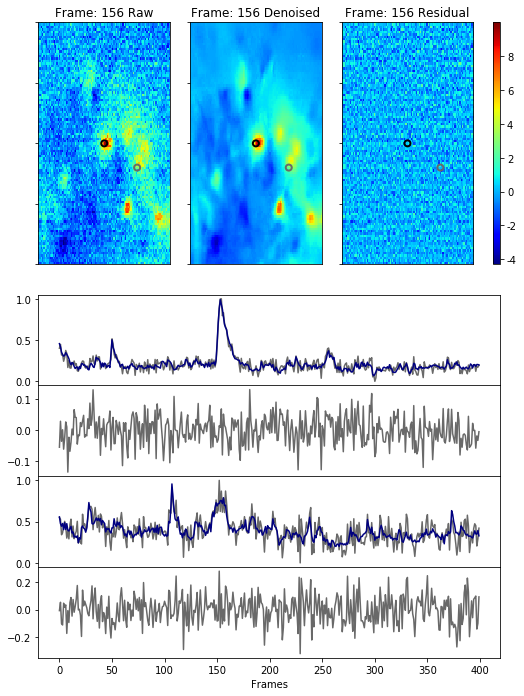

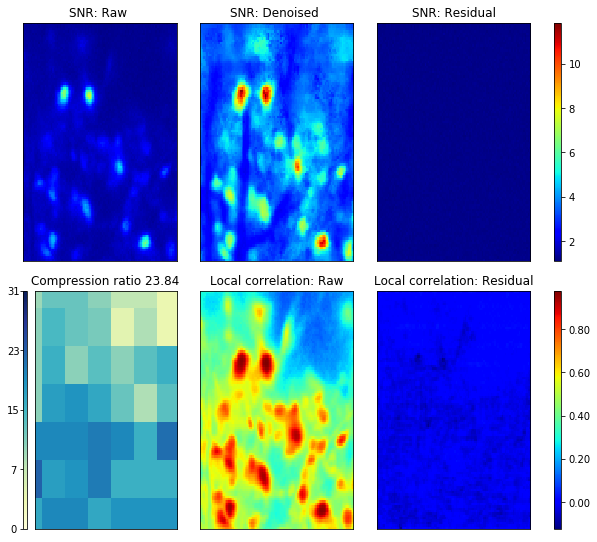

In [52]:
mpdf_plot.pdf_write(foreground,
                    denoised_foreground,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[75, 125],
                    pixel_coor2=[85, 150],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Endoscope_PMD.pdf')
plt.show()

## Save Results For Video

In [53]:
np.savez(os.path.join(ext, "data", "Endoscope_PMD.npz"), foreground, denoised_foreground)

In [54]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [55]:
np.savez(os.path.join(ext, "data", "Endoscope_Components_PMD.npz"), U, V)

In [56]:
del foreground, denoised_foreground

# Dendritic

In [57]:
dataset = "Dendritic"
filename = os.path.join(ext, "data", "xp33_60pct_210_192_-1000_rig.npy")
block_height = 16
block_width = 16

In [58]:
mov = np.load(filename).astype(np.float64)[:192,:,:].copy()  # crop bottom 18 so we can decimate here too
fov_height, fov_width, num_frames = mov.shape
num_pixels = fov_height * fov_width

## Preprocess

In [59]:
# Remove Any Nan Pixels
mov[np.isnan(mov)] = 0

# Remove Movie-Wise Median
mov -= np.median(mov)

# Normalize By Pixelwise Standard Deviation
pixelwise_std = np.reshape(np.sqrt(psd_noise_estimate(np.reshape(mov, (num_pixels, num_frames)))),
                           (fov_height, fov_width, 1))
mov /= pixelwise_std
mov[np.isnan(mov)] = 0

## Simulate Thresholds

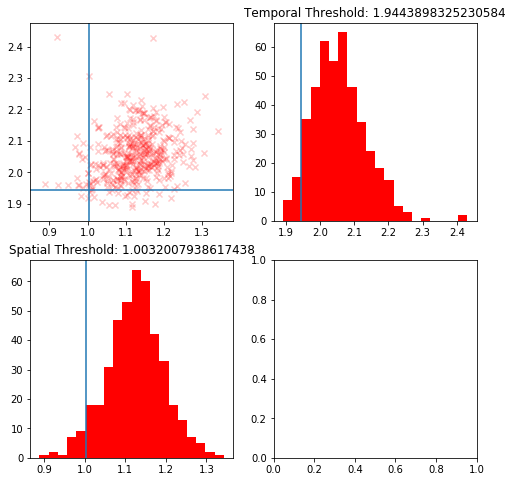

In [60]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, conf=5, plot=True)

## Run Decomposition

In [61]:
# Perform 4x Overlapping Blockwise PMD In Parallel
spatial_components,\
temporal_components,\
block_ranks,\
block_indices,\
block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                            mov, block_height, block_width,
                                            spatial_thresh, temporal_thresh,
                                            max_components, consec_failures,
                                            max_iters_main, max_iters_init, tol,
                                            d_sub=d_sub, t_sub=t_sub)

# Use Compressed Components To Reconstruct Denoise Video
mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                      block_height, block_width,
                                                      spatial_components,
                                                      temporal_components,
                                                      block_ranks,
                                                      block_indices,
                                                      block_weights)) 

## Run Timing Evaluation

In [62]:
def time_dec_pmd():
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)

timeit.timeit(time_dec_pmd, number=5)/5

3.161571379399902

## Produce Performance Diagnostics

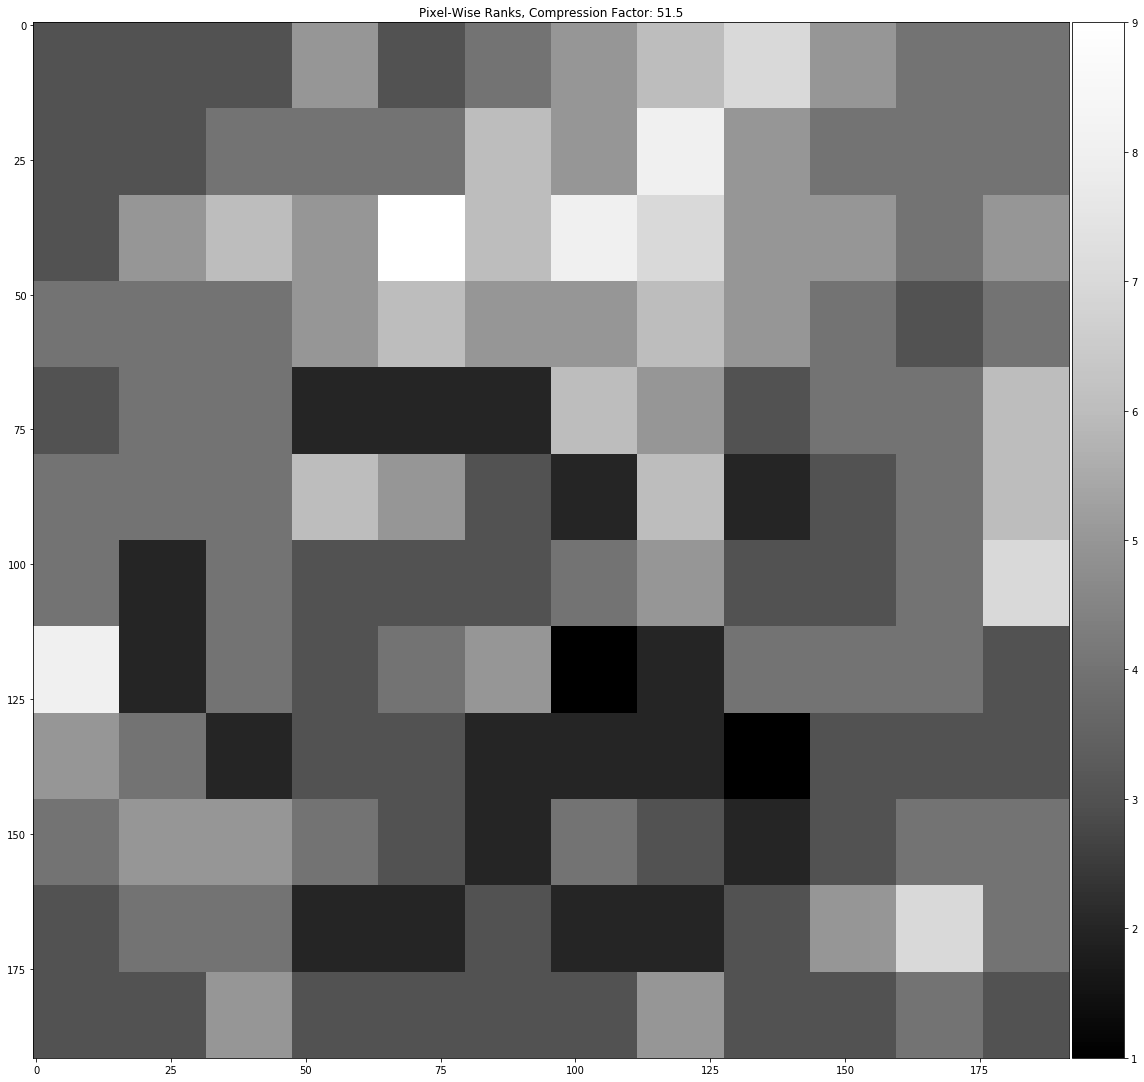

In [63]:
pixelwise_ranks(block_ranks['no_skew']['full'], 
                fov_height, fov_width, num_frames,
                block_height, block_width)

Local correlation:  range [-9.3e-03 9.0e-01]
Local correlation:  range [-8.8e-01 1.0e+00]
Local correlation:  range [-1.8e-01 1.1e-01]


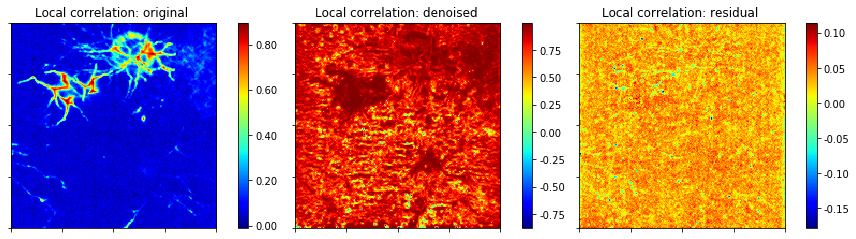

In [64]:
comparison_plot([mov, mov_denoised], plot_orientation="vertical")

## Generate Paper Figs

Frame:  range [-1.8e+00 2.3e+01]
Frame:  range [-7.6e-01 2.1e+01]
Frame:  range [-4.4e+00 7.0e+00]
SNR:  range [1.1e+00 5.7e+00]
SNR:  range [1.2e+00 1.6e+01]
SNR:  range [1.0e+00 2.0e+00]
Local correlation:  range [1.9e-02 9.0e-01]
Local correlation:  range [-1.8e-01 1.2e-01]


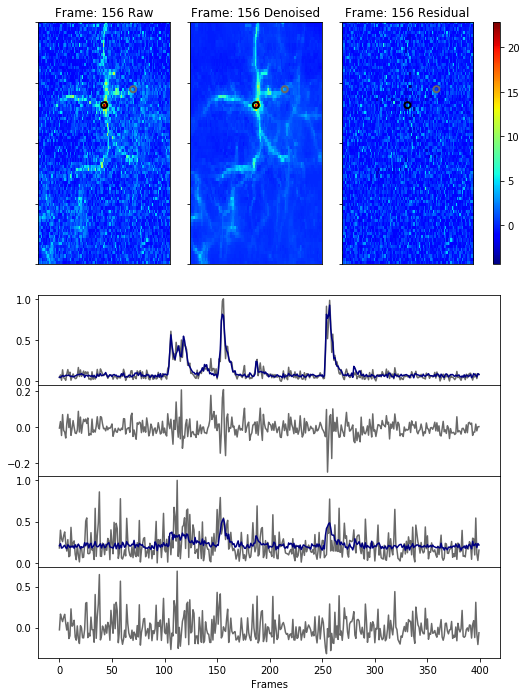

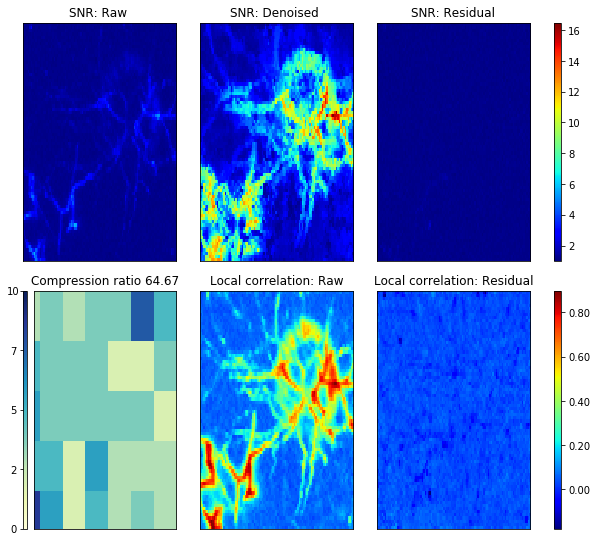

In [65]:
mpdf_plot.pdf_write(mov,
                    mov_denoised,
                    ranks=block_ranks['no_skew']['full'],
                    pixel_coor1=[26, 94],
                    pixel_coor2=[21, 116],
                    frame_idx=756,
                    trace_seg=[600,1000],
                    plot_colormap='jet',
                    nblocks=[int(fov_height/block_height),
                             int(fov_width/block_width)],
                    zoom_box=50,
                    pdf_name='Dendritic_PMD.pdf')
plt.show()

In [66]:
play_cv2(np.hstack([mov, mov_denoised, mov-mov_denoised]), magnification=2)

## Save Reuslts For Video

In [67]:
np.savez(os.path.join(ext, "data", "Dendritic_PMD.npz"), mov, mov_denoised)

In [68]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [69]:
np.savez(os.path.join(ext, "data", "Dendritic_Components_PMD.npz"), U, V)